In [1]:
import copy
import os
import random
import shutil
import tarfile
from copy import deepcopy
from urllib.request import urlretrieve

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from tqdm import tqdm

pd.set_option("display.max_colwidth", None)
random.seed(42)

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

25

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
def display_image_grid(images_filepaths, predicted_labels=(), predicted_probs=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        predicted_prob = predicted_probs[i] if predicted_probs else 1
        color = "green" if true_label == predicted_label else "red"
        if color=='red':
            print(f'true_label: {true_label}, predicted_label: {predicted_label}')
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(f'{predicted_label}, p={predicted_prob:.2f}', color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [5]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    print(filepath, os.path.exists(filepath))
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return False

    with TqdmUpTo(
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        miniters=1,
        desc=os.path.basename(filepath),
    ) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n
    return True


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

In [6]:
url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"

In [7]:
# dataset_directory = os.path.join(os.environ["HOME"], "datasets/food101")
if os.name == "nt":  # Windows
    dataset_directory = "datasets/food101/"
else:  # POSIX (Linux, macOS, etc.)
    home_path = os.environ.get("HOME")
    dataset_directory = os.path.join(home_path, "datasets/food101")

In [8]:
filepath = os.path.join(dataset_directory, "food101.tar.gz")
need_to_extract = download_url(
    url=url,
    filepath=filepath,
)
if need_to_extract:
    extract_archive(filepath)

/home/kirill/datasets/food101/food101.tar.gz True
Filepath already exists. Skipping download.


### Dataloaders


In [9]:
all_images_filepaths = []
images_all_path = os.path.join(dataset_directory, "food-101/images")
class_names = os.listdir(images_all_path)
for class_name in class_names:
    all_images_filepaths.extend(
        [
            *sorted(
                [
                    os.path.join(os.path.join(images_all_path, f"{class_name}"), f)
                    for f in os.listdir(os.path.join(images_all_path, f"{class_name}"))
                ]
            )
        ]
    )

In [10]:
def visualize_augmentations_A(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [11]:
class OwnDataset(Dataset):
    def __init__(self, class_names, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform
        self.labels_dict = {class_name:i for i, class_name in enumerate(class_names)}
        
    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels_dict[os.path.normpath(image_filepath).split(os.sep)[-2]]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label#torch.tensor([label])

In [12]:
NUM_WORKERS = os.cpu_count()


def split_data(dataset, val_size=0.2, seed=42):
    """ """
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(
        dataset, [1 - val_size, val_size], generator=generator
    )

    return train_data, test_data


def create_dataloaders(
    data_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS,
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
        data_dir: Path to image directory.
        train_transform: torchvision transforms to perform on training data.
        test_transform: torchvision transforms to perform on valid and testing data.
        batch_size: Number of samples per batch in each of the DataLoaders.
        num_workers: An integer for number of workers per DataLoader.

    Returns:
        A tuple of (train_dataloader, valid_dataloader, test_dataloader, class_names).
        Where class_names is a list of the target classes.
        Example usage:
        train_dataloader, valid_dataloader, test_dataloader, class_names = \
            = create_dataloaders(data_dir=path/to/train_dir,
                                train_transform=some_transform,
                                test_transform=some_transform,
                                batch_size=32,
                                num_workers=4)
    """

    all_images_filepaths = []
    class_names = os.listdir(data_dir)
    for class_name in class_names:
        all_images_filepaths.extend(
            [
                *sorted(
                    [
                        os.path.join(os.path.join(data_dir, f"{class_name}"), f)
                        for f in os.listdir(os.path.join(data_dir, f"{class_name}"))
                    ]
                )
            ]
        )

    # Get class names
    class_names = os.listdir(data_dir)
    random.shuffle(all_images_filepaths)
    # all_images_filepaths = all_images_filepaths[:250]
    # all_images_filepaths = [i for i in deepcopy(all_images_filepaths) if cv2.imread(i) is not None]
    train_images_filepaths = all_images_filepaths[:int(0.8 * len(all_images_filepaths))]
    val_images_filepaths = all_images_filepaths[int(0.8 * len(all_images_filepaths)):-20]
    test_images_filepaths = all_images_filepaths[-20:]
    
    train_set = OwnDataset(class_names=class_names, images_filepaths=train_images_filepaths, transform=train_transform)
    valid_set = OwnDataset(class_names=class_names, images_filepaths=val_images_filepaths, transform=test_transform)
    test_set = OwnDataset(class_names=class_names, images_filepaths=test_images_filepaths, transform=test_transform)

    visualize_augmentations_A(train_set)
    
    
    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )  
    vaild_dataloader = DataLoader(
        valid_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    test_dataloader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, vaild_dataloader, test_dataloader, class_names, train_images_filepaths, val_images_filepaths, test_images_filepaths


In [13]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [14]:
from pathlib import Path

data_path = Path(dataset_directory)
image_path = data_path / "food-101" / "images"

In [15]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.0, 0.2), rotate=(-45, 45), shear=(-15, 15), mode=cv2.BORDER_REFLECT_101, p=0.5),
        A.CoarseDropout(p=0.55),
        A.Normalize(
            mean=(
                0.485,
                0.456,
                0.406,
            ),  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
            std=(0.229, 0.224, 0.225),
        ),  # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(
            mean=(
                0.485,
                0.456,
                0.406,
            ),  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
            std=(0.229, 0.224, 0.225),
        ),  # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
        ToTensorV2(),
    ]
)

In [16]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    device: torch.device,
) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    scheduler: A PyTorch scheduler.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    # Loop through data loader data batches
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    scheduler.step()
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    valid_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    valid_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Make sure model on target device
    model.to(device)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=valid_dataloader, loss_fn=loss_fn, device=device
        )
        # print(scheduler.get_last_lr(), type(scheduler.get_last_lr()))
        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"lr: {scheduler.get_last_lr()[0]:.4f} "
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        torch.save(
            {
                "epoch": epochs,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": loss_fn,
                "results" : results
            },
            f"{epochs}_iter.pth",
        )
        print(train_loss, train_acc)

    # Return the filled results at the end of the epochs
    return results

/home/kirill/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## MobileNet

In [17]:
weights = (
    torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
)  # .DEFAULT = best available weights from pretraining on ImageNet
auto_transforms = weights.transforms()
model = torchvision.models.mobilenet_v3_large(
    weights="MobileNet_V3_Large_Weights.IMAGENET1K_V2"
)
auto_transforms

auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [18]:
model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [19]:
# for param in model.features.parameters():
#     param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=960,
        out_features=1280,  # same number of output units as our number of classes
        bias=True,
    ),
    torch.nn.Hardswish(),
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape,  # same number of output units as our number of classes
        bias=True,
    ),
)#.to(device)

In [20]:
summary(
    model,
    input_size=(
        32,
        3,
        224,
        224,
    ),  # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MobileNetV3 (MobileNetV3)                                    [32, 3, 224, 224]    [32, 101]            --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [32, 16, 112, 112]   [32, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [32, 16, 112, 112]   [32, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [32, 16, 112, 112]   [32, 16, 112

## EfficientNet

In [21]:
# weights = (
#     torchvision.models.EfficientNet_B0_Weights.DEFAULT
# )  # .DEFAULT = best available weights from pretraining on ImageNet
# auto_transforms = weights.transforms()

# model = torchvision.models.efficientnet_v2_s(
#     weights="EfficientNet_V2_S_Weights.IMAGENET1K_V1"
# )
# auto_transforms

In [22]:
# # Выберете слои, через которые не будут течь градиенты
# for param in model.features.parameters():
#     param.requires_grad = False

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# output_shape = len(class_names)
# model.classifier = torch.nn.Sequential(
#     torch.nn.Dropout(p=0.2, inplace=True),
#     torch.nn.Linear(
#         in_features=1280,
#         out_features=output_shape,  # same number of output units as our number of classes
#         bias=True,
#     ),
# )#.to(device)

In [23]:
# model.classifier

Взглянем на модель

In [24]:
# summary(
#     model,
#     input_size=(
#         32,
#         3,
#         224,
#         224,
#     ),  # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
#     verbose=0,
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )

# Train (1 point)

In [25]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # дефолт
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.92)
n_epochs = 30

In [26]:
NUM_WORKERS

4

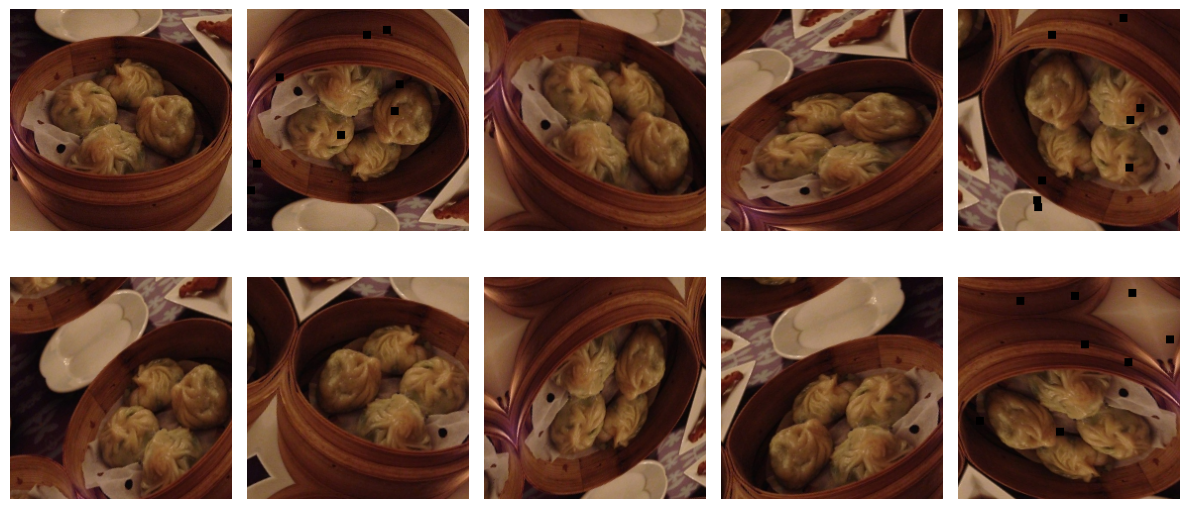

In [27]:
batch_size = 100

train_dataloader, valid_dataloader, test_dataloader, class_names, train_images_filepaths, val_images_filepaths, test_images_filepaths = create_dataloaders(
    data_dir=image_path,
    train_transform=train_transform,
    test_transform=test_transform,
    batch_size=batch_size,
    num_workers=2,
)

# train_dataloader, valid_dataloader,test_dataloader, class_names

In [28]:
len(train_dataloader.dataset)

80800

In [29]:
image_path

PosixPath('/home/kirill/datasets/food101/food-101/images')

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Setup training and save the results
results = train(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    epochs=n_epochs,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

808it [05:21,  2.52it/s]0:00<?, ?it/s]


Epoch: 1 | train_loss: 1.6681 | train_acc: 0.5729 | test_loss: 1.4182 | test_acc: 0.6294 | lr: 0.0009 


  3%|▎         | 1/30 [06:24<3:06:00, 384.83s/it]

1.6680853260625708 0.5729207920792085


808it [05:38,  2.39it/s]


Epoch: 2 | train_loss: 1.0626 | train_acc: 0.7137 | test_loss: 1.0894 | test_acc: 0.7118 | lr: 0.0008 


  7%|▋         | 2/30 [13:04<3:03:33, 393.35s/it]

1.062630774803681 0.7137252475247523


808it [05:12,  2.58it/s]


Epoch: 3 | train_loss: 0.8624 | train_acc: 0.7616 | test_loss: 1.1802 | test_acc: 0.6884 | lr: 0.0008 


 10%|█         | 3/30 [19:18<2:53:11, 384.86s/it]

0.8624038590431804 0.7616089108910873


808it [05:17,  2.54it/s]


Epoch: 4 | train_loss: 0.7296 | train_acc: 0.7952 | test_loss: 0.9905 | test_acc: 0.7409 | lr: 0.0007 


 13%|█▎        | 4/30 [25:39<2:46:03, 383.23s/it]

0.7296309069094091 0.7951856435643563


808it [04:25,  3.05it/s]


Epoch: 5 | train_loss: 0.6229 | train_acc: 0.8214 | test_loss: 0.9463 | test_acc: 0.7574 | lr: 0.0007 


 17%|█▋        | 5/30 [30:56<2:29:45, 359.42s/it]

0.6229222075700169 0.8213737623762386


808it [04:51,  2.77it/s]


Epoch: 6 | train_loss: 0.5311 | train_acc: 0.8451 | test_loss: 0.9351 | test_acc: 0.7612 | lr: 0.0006 


 20%|██        | 6/30 [36:44<2:22:06, 355.26s/it]

0.531149509077025 0.8451113861386147


808it [04:30,  2.98it/s]


Epoch: 7 | train_loss: 0.4488 | train_acc: 0.8671 | test_loss: 1.0045 | test_acc: 0.7561 | lr: 0.0006 


 23%|██▎       | 7/30 [42:08<2:12:18, 345.14s/it]

0.44879746023971256 0.8670544554455447


808it [04:56,  2.72it/s]


Epoch: 8 | train_loss: 0.3791 | train_acc: 0.8868 | test_loss: 0.9491 | test_acc: 0.7720 | lr: 0.0005 


 27%|██▋       | 8/30 [47:58<2:07:05, 346.59s/it]

0.37914298852850303 0.8867698019801976


808it [04:22,  3.08it/s]


Epoch: 9 | train_loss: 0.3094 | train_acc: 0.9057 | test_loss: 0.9790 | test_acc: 0.7796 | lr: 0.0005 


 30%|███       | 9/30 [53:18<1:58:24, 338.32s/it]

0.3093971698867655 0.9057178217821763


808it [04:42,  2.86it/s]


Epoch: 10 | train_loss: 0.2640 | train_acc: 0.9183 | test_loss: 0.9955 | test_acc: 0.7815 | lr: 0.0004 


 33%|███▎      | 10/30 [58:58<1:53:00, 339.01s/it]

0.2640130300406772 0.9182797029702934


808it [04:42,  2.86it/s]


Epoch: 11 | train_loss: 0.2219 | train_acc: 0.9302 | test_loss: 0.9903 | test_acc: 0.7849 | lr: 0.0004 


 37%|███▋      | 11/30 [1:04:33<1:46:55, 337.64s/it]

0.22194803673036323 0.9302103960396025


808it [04:52,  2.76it/s]


Epoch: 12 | train_loss: 0.1815 | train_acc: 0.9431 | test_loss: 1.1061 | test_acc: 0.7788 | lr: 0.0004 


 40%|████      | 12/30 [1:10:21<1:42:18, 341.01s/it]

0.18153401170073463 0.9431311881188134


808it [04:21,  3.08it/s]


Epoch: 13 | train_loss: 0.1604 | train_acc: 0.9497 | test_loss: 1.0535 | test_acc: 0.7859 | lr: 0.0003 


 43%|████▎     | 13/30 [1:15:33<1:34:03, 331.96s/it]

0.1604313135059495 0.9496782178217867


808it [05:00,  2.69it/s]


Epoch: 14 | train_loss: 0.1326 | train_acc: 0.9582 | test_loss: 1.0717 | test_acc: 0.7904 | lr: 0.0003 


 47%|████▋     | 14/30 [1:21:29<1:30:27, 339.21s/it]

0.13261510852475347 0.9582425742574339


808it [04:41,  2.87it/s]


Epoch: 15 | train_loss: 0.1180 | train_acc: 0.9623 | test_loss: 1.0900 | test_acc: 0.7926 | lr: 0.0003 


 50%|█████     | 15/30 [1:27:07<1:24:45, 339.05s/it]

0.11803842212493061 0.9622772277227813


808it [04:41,  2.87it/s]


Epoch: 16 | train_loss: 0.0978 | train_acc: 0.9687 | test_loss: 1.1133 | test_acc: 0.7942 | lr: 0.0003 


 53%|█████▎    | 16/30 [1:32:48<1:19:15, 339.71s/it]

0.09776080265009574 0.9687128712871383


808it [05:12,  2.59it/s]


Epoch: 17 | train_loss: 0.0844 | train_acc: 0.9732 | test_loss: 1.1235 | test_acc: 0.7943 | lr: 0.0002 


 57%|█████▋    | 17/30 [1:39:06<1:16:05, 351.19s/it]

0.08439657731110801 0.9732178217821885


808it [05:36,  2.40it/s]


Epoch: 18 | train_loss: 0.0757 | train_acc: 0.9764 | test_loss: 1.1420 | test_acc: 0.8017 | lr: 0.0002 


 60%|██████    | 18/30 [1:45:47<1:13:14, 366.19s/it]

0.07568992370403012 0.9764108910891198


808it [05:43,  2.35it/s]


Epoch: 19 | train_loss: 0.0693 | train_acc: 0.9776 | test_loss: 1.1106 | test_acc: 0.7997 | lr: 0.0002 


 63%|██████▎   | 19/30 [1:52:36<1:09:28, 378.97s/it]

0.06932376665933436 0.9776485148514954


808it [05:56,  2.27it/s]


Epoch: 20 | train_loss: 0.0590 | train_acc: 0.9812 | test_loss: 1.1875 | test_acc: 0.7972 | lr: 0.0002 


 67%|██████▋   | 20/30 [1:59:31<1:04:56, 389.61s/it]

0.05895142808630325 0.9812252475247619


808it [04:59,  2.69it/s]


Epoch: 21 | train_loss: 0.0535 | train_acc: 0.9831 | test_loss: 1.1855 | test_acc: 0.7997 | lr: 0.0002 


 70%|███████   | 21/30 [2:05:28<56:59, 379.99s/it]  

0.05350957376194316 0.9831435643564447


808it [05:06,  2.63it/s]


Epoch: 22 | train_loss: 0.0490 | train_acc: 0.9841 | test_loss: 1.2123 | test_acc: 0.7984 | lr: 0.0002 


 73%|███████▎  | 22/30 [2:11:32<50:01, 375.14s/it]

0.048989777462176594 0.9841460396039685


808it [05:01,  2.68it/s]


Epoch: 23 | train_loss: 0.0459 | train_acc: 0.9853 | test_loss: 1.1953 | test_acc: 0.8005 | lr: 0.0001 


 77%|███████▋  | 23/30 [2:17:32<43:13, 370.55s/it]

0.04594578545904801 0.9852970297029786


808it [05:12,  2.58it/s]


Epoch: 24 | train_loss: 0.0397 | train_acc: 0.9874 | test_loss: 1.1939 | test_acc: 0.8026 | lr: 0.0001 


 80%|████████  | 24/30 [2:23:44<37:06, 371.06s/it]

0.039747168987731236 0.9873886138613932


808it [05:16,  2.56it/s]


Epoch: 25 | train_loss: 0.0352 | train_acc: 0.9893 | test_loss: 1.2279 | test_acc: 0.8039 | lr: 0.0001 


 83%|████████▎ | 25/30 [2:30:00<31:03, 372.61s/it]

0.03520329627709804 0.989306930693075


808it [05:19,  2.53it/s]


Epoch: 26 | train_loss: 0.0356 | train_acc: 0.9887 | test_loss: 1.2133 | test_acc: 0.8072 | lr: 0.0001 


 87%|████████▋ | 26/30 [2:36:11<24:48, 372.16s/it]

0.03563581259058452 0.9887252475247591


808it [04:06,  3.27it/s]


Epoch: 27 | train_loss: 0.0313 | train_acc: 0.9901 | test_loss: 1.2157 | test_acc: 0.8061 | lr: 0.0001 


 90%|█████████ | 27/30 [2:41:08<17:28, 349.41s/it]

0.031283014697728144 0.990074257425749


808it [04:09,  3.24it/s]


Epoch: 28 | train_loss: 0.0264 | train_acc: 0.9915 | test_loss: 1.2219 | test_acc: 0.8068 | lr: 0.0001 


 93%|█████████▎| 28/30 [2:46:06<11:08, 334.04s/it]

0.026408834469842952 0.9914851485148568


808it [04:06,  3.27it/s]


Epoch: 29 | train_loss: 0.0274 | train_acc: 0.9912 | test_loss: 1.2187 | test_acc: 0.8092 | lr: 0.0001 


 97%|█████████▋| 29/30 [2:51:02<05:22, 322.54s/it]

0.027426766504396426 0.9912004950495106


808it [04:09,  3.24it/s]


Epoch: 30 | train_loss: 0.0254 | train_acc: 0.9924 | test_loss: 1.2406 | test_acc: 0.8077 | lr: 0.0001 


100%|██████████| 30/30 [2:56:00<00:00, 352.02s/it]

0.025364226240481454 0.9924257425742623
[INFO] Total training time: 10560.645 seconds


In [31]:
# model.eval()
# model.load_state_dict(torch.load("30_iter.pth")["model_state_dict"])

In [32]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

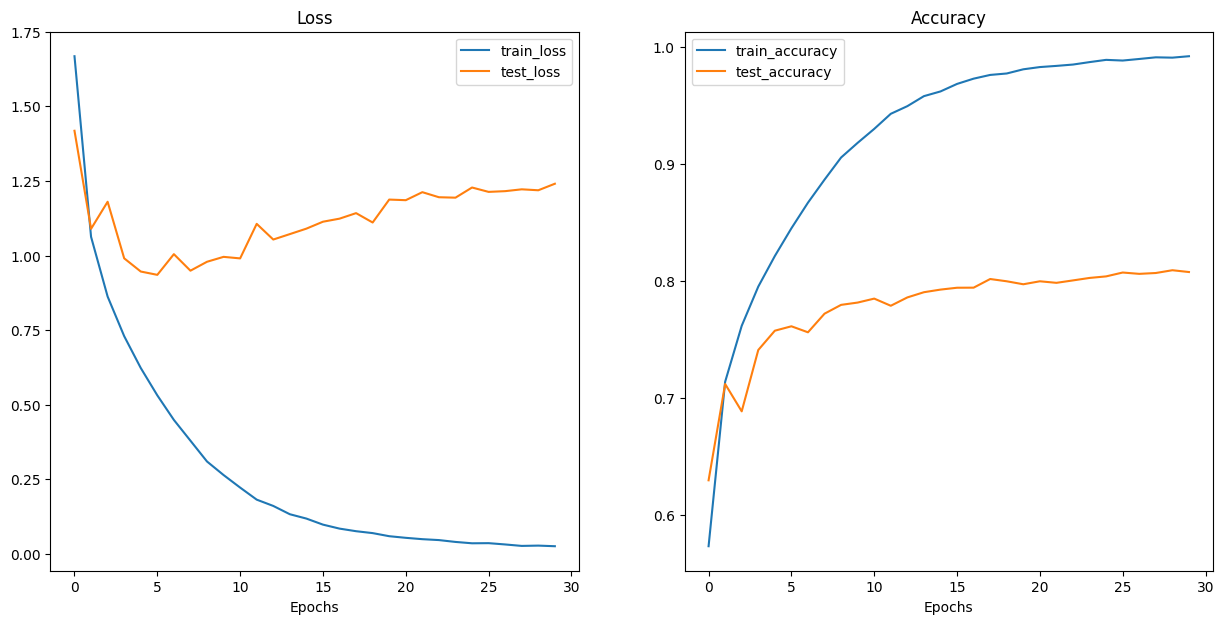

In [33]:
plot_loss_curves(torch.load(f"{n_epochs}_iter.pth")['results'])

In [34]:
test_loss, test_acc = test_step(
    model= model,
    dataloader= test_dataloader,
    loss_fn= loss_fn,
    device= device,
)

true_label: panna_cotta, predicted_label: strawberry_shortcake
true_label: fried_rice, predicted_label: paella
true_label: paella, predicted_label: pizza


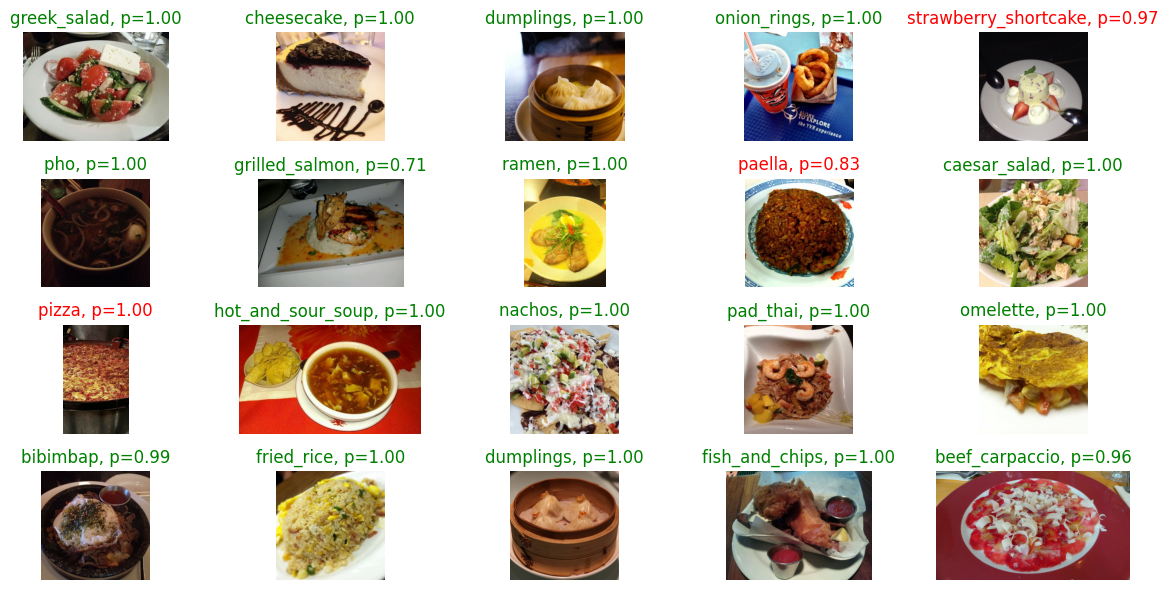

In [41]:
model = model.eval()
predicted_labels = []
predicted_probs = []
labels_dict_inverted = {i:class_name for i, class_name in enumerate(class_names)}
with torch.no_grad():
    for images, y in test_dataloader:
        # print(images)
        images = images.to(device, non_blocking=True)
        output = model(images)
        predictions_list = list(output.argmax(dim=1).cpu().numpy())
        predictions_prob_list = list(torch.max(torch.softmax(output, dim=1), dim=1))
        predicted_labels.extend(list(map(lambda x: labels_dict_inverted[x], predictions_list)))
        predicted_probs.extend(predictions_prob_list[0].cpu().numpy())
display_image_grid(test_images_filepaths, predicted_labels, predicted_probs)